# SWEET-CROSS population, GDP and ERA estimations in CROSS scenarios V2022-09
Code to calcualte the harmonising assumptions for population, GDP and ERA in the CROSS scenarios V2022-09

Copyright (c) 2021-2023, ETH Zurich, Energy Science Center, Adriana Marcucci

Distributed under the terms of the Apache License, Version 2.0

In [2]:
import pandas as pd
import numpy as np
import requests
import json
import matplotlib.pyplot as plt 
import io

## Data from Energieperpectiven 2050+ 
We compare all our assumption to the [EP2050+](https://www.bfe.admin.ch/bfe/de/home/politik/energieperspektiven-2050-plus.html). The values for the EP2050+ are taken from:
* [Energieperspektiven 2050+. Tabellen und Grafiken des Kurzberichts (12.04.2022)](https://www.bfe.admin.ch/bfe/de/home/politik/energieperspektiven-2050-plus.exturl.html/aHR0cHM6Ly9wdWJkYi5iZmUuYWRtaW4uY2gvZGUvcHVibGljYX/Rpb24vZG93bmxvYWQvMTAzMjQ=.html)
* [EP2050+ Szenarienergebnisse ZERO Basis](https://www.bfe.admin.ch/bfe/de/home/politik/energieperspektiven-2050-plus.exturl.html/aHR0cHM6Ly9wdWJkYi5iZmUuYWRtaW4uY2gvZGUvcHVibGljYX/Rpb24vZG93bmxvYWQvMTA0MzQ=.html)

In [3]:
# Load the EP2050+ data
from io import BytesIO
from zipfile import ZipFile
import urllib.request

url = 'https://www.bfe.admin.ch/bfe/de/home/politik/energieperspektiven-2050-plus.exturl.html/aHR0cHM6Ly9wdWJkYi5iZmUuYWRtaW4uY2gvZGUvcHVibGljYX/Rpb24vZG93bmxvYWQvMTAzMjQ=.html'
ep2050 = pd.read_excel(pd.ExcelFile(url), 'Tabelle 1',index_col=[2],skiprows=11,header=[0], nrows= 10)

url = urllib.request.urlopen('https://www.bfe.admin.ch/bfe/de/home/politik/energieperspektiven-2050-plus.exturl.html/aHR0cHM6Ly9wdWJkYi5iZmUuYWRtaW4uY2gvZGUvcHVibGljYX/Rpb24vZG93bmxvYWQvMTA0MzQ=.html')

with ZipFile(BytesIO(url.read())) as my_zip_file:
    contained_file ='EP2050+_Szenarienergebnisse_ZERO-Basis/EP2050+_Ergebnissynthese_2020-2060_ZERO-Basis_KKW50_ausgeglicheneJahresbilanz_2022-04-12.xlsx'
    #Load the macro-economic data
    ep2050_macro=pd.read_excel(my_zip_file.open(contained_file), sheet_name='01 Annahmen und Rahmendaten',index_col=[0,1],skiprows=11, nrows= 4)
    #Load the ERA
    ep2050_ebf=pd.read_excel(my_zip_file.open(contained_file), sheet_name='01 Annahmen und Rahmendaten',index_col=[0,1,2],skiprows=84, nrows= 25)

# Remove the empty column to the left
ep2050_macro.index = ep2050_macro.index.droplevel(0)
ep2050_macro.index = ep2050_macro.index.str.strip()

ep2050_ebf.index = ep2050_ebf.index.droplevel([0,1])
ep2050_ebf.index = ep2050_ebf.index.str.strip()

## Population

The population projections are based on:

* [BFS historical population (25.08.2022)](https://www.bfs.admin.ch/asset/de/px-x-0102020000_101) 
* [BFS population projections (28.05.2020)](https://www.bfs.admin.ch/asset/de/px-x-0104000000_102)  


We take the historical data until 2021 and use the growth rate of the projections from 2022

In [4]:
# Load the historical population from the BFS API

url_population = "https://www.pxweb.bfs.admin.ch/api/v1/de/px-x-0102020000_101/px-x-0102020000_101.px"
query = {
  "query": [
    {
      "code": "Kanton",
      "selection": {
        "filter": "item",
        "values": ["0"] # All cantons together
      }
    },
    {
      "code": "Staatsangehörigkeit (Kategorie)",
      "selection": {
        "filter": "item",
        "values": ["0"] # All residents
      }
    },
    {
      "code": "Geschlecht",
      "selection": {
        "filter": "item",
        "values": ["0"] # All genders
      }
    },
    {
      "code": "Demografische Komponente",
      "selection": {
        "filter": "item",
        "values": ["12"] # Value by end of december 
      }
    }
  ],
  "response": {
    "format": "json-stat"
  }
}

pop_hist_from_api = requests.post(url_population, json = query).json()
# Extract the dictionaries with the years and the scenario names
year_names = pop_hist_from_api['dataset']['dimension']['Jahr']['category']['label']
# Extract the data - Data is one single array
pop_hist_data = pop_hist_from_api['dataset']['value']
# Create a dataframe with the data
pop_hist = pd.Series(pop_hist_data,index=year_names.values())
# Convert the index from string to integers
pop_hist.index = pop_hist.index.astype('int64')

In [5]:
# Load the population projections data from the BFS API

url_pop_proj = 'https://www.pxweb.bfs.admin.ch/api/v1/de/px-x-0104000000_102/px-x-0104000000_102.px'

query = {
  "query": [
    {
      "code": "Szenario-Variante",
      "selection": {
        "filter": "item",
        "values": ["0","1","2"]  #This are scenarios AA-00-2020, BB-00-2020 and CC-00-2020
      }
    },
    {
      "code": "Staatsangehörigkeit (Kategorie)",
      "selection": {
        "filter": "item",
        "values": ["0"] # All residents
      }
    },
    {
      "code": "Geschlecht",
      "selection": {
        "filter": "item",
        "values": ["0"] # All genders
      }
    },
    {
      "code": "Alter",
      "selection": {
        "filter": "item",
        "values": ["0"] # All ages
      }
    },
    {
      "code": "Beobachtungseinheit",
      "selection": {
        "filter": "item",
        "values": ["6"] # Value by end of december 
      }
    }
  ],
  "response": {
    "format": "json-stat"
  }
}   
    

pop_proj_from_api = requests.post(url_pop_proj, json = query).json()
# Extract the dictionaries with the years and the scenario names
year_names = pop_proj_from_api['dataset']['dimension']['Jahr']['category']['label']
sce_names = pop_proj_from_api['dataset']['dimension']['Szenario-Variante']['category']['label']
# Extract the data - Data is one single array
pop_proj_data = pop_proj_from_api['dataset']['value']
# Split the array into the number of scenarios and transpose it
pop_proj_data_sce = np.transpose(np.array_split(pop_proj_data, len(sce_names)))
# Create a dataframe with the data
pop_proj = pd.DataFrame(pop_proj_data_sce,columns=sce_names.values(),index=year_names.values())
# Convert the index from string to integers
pop_proj.index = pop_proj.index.astype('int64')

<Figure size 432x288 with 0 Axes>

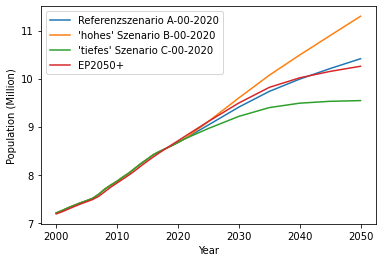

,Referenzszenario A-00-2020,'hohes' Szenario B-00-2020,'tiefes' Szenario C-00-2020,EP2050+
2030,9.406496,9.597714,9.213721,9.492
2035,9.733351,10.068774,9.396539,9.817
2040,9.989599,10.491198,9.488566,10.016
2045,10.208889,10.895082,9.527629,10.15
2050,10.413712,11.297964,9.542141,10.257


In [6]:
# Calculate the projections with the updated historical years
years_hist = np.arange(2000,2022,1)
years_proj = np.arange(2025,2051,5)

pop_cross = pd.DataFrame(index=np.append(years_hist,years_proj).tolist(),columns=pop_proj.columns)

# Copy historical values
for sce in sce_names.values():
    pop_cross.loc[years_hist,sce] = pop_hist[years_hist]/1e6 #Divide by 1e6 to have the values in Million
    # From 2021 to 2025
    pop_cross.loc[2025,sce] = pop_cross.loc[2021,sce] * pop_proj.loc[2025,sce]/pop_proj.loc[2021,sce]
# From 2025 to 2050
for i in range(1, len(years_proj)):
    pop_cross.loc[years_proj[i],:] = pop_cross.loc[years_proj[i-1],:]*pop_proj.loc[years_proj[i],:]/pop_proj.loc[years_proj[i-1],:]

# Add the EP2050+ data for comparison
pop_cross.loc[years_hist,'EP2050+']=ep2050.loc['Bevölkerung',years_hist]/1000
pop_cross.loc[years_proj,'EP2050+']=ep2050.loc['Bevölkerung',years_proj]/1000

plt.figure()
pop_cross.plot.line()
plt.xlabel('Year')
plt.ylabel('Population (Million)')
plt.show()

pop_cross.tail(5)

## Households

The households projections are based on:

* [BFS 07.10.2021 historical households](https://www.bfs.admin.ch/bfs/de/home/statistiken/bevoelkerung/stand-entwicklung/haushalte.assetdetail.18845791.html) 
* [BFS 25.05.2021 households projections](https://www.bfs.admin.ch/bfs/de/home/statistiken/bevoelkerung/zukuenftige-entwicklung/haushaltsszenarien.assetdetail.16344849.html)  

We take the historical data until 2020 and use the growth rate of the projections from 2021

In [7]:
# Load the historical household data
url = 'https://dam-api.bfs.admin.ch/hub/api/dam/assets/18845791/master'
# Read all the sheets from the file, each sheet is a year
hh_historical_file = pd.ExcelFile(url)
y_hh_hist =  np.arange(2012,2021,1)
hh_hist = pd.Series(dtype = "float")

for y in np.char.mod('%d',y_hh_hist):
    df_y = pd.read_excel(hh_historical_file, y,index_col=[0],skiprows=[0],header=[0])
    hh_hist.loc[y]= df_y.loc['Schweiz','Total']

# Convert the index from string to integers
hh_hist.index = hh_hist.index.astype('int64')

In [8]:
# Load the household projection data
url = 'https://dam-api.bfs.admin.ch/hub/api/dam/assets/16344849/master'
# Read all the sheets from the file, each sheet is a scenario
hh_proj_file = pd.ExcelFile(url)
y_hh_proj =  np.arange(2020,2051,1)
hh_proj = pd.DataFrame(index=y_hh_proj,columns=hh_proj_file.sheet_names)

for sce in hh_proj_file.sheet_names:
    df_sce = pd.read_excel(hh_proj_file, sce,index_col=[0],skiprows=[0],header=[0])
    hh_proj.loc[y_hh_proj,sce]= df_sce.loc['Schweiz',y_hh_proj]

# Convert the index from string to integers
hh_proj.index = hh_proj.index.astype('int64')    

<Figure size 432x288 with 0 Axes>

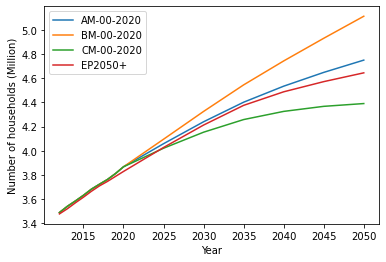

,AM-00-2020,BM-00-2020,CM-00-2020,EP2050+
2012,3.488738,3.488738,3.488738,3.477489
2013,3.540641,3.540641,3.540641,3.520523
2014,3.584789,3.584789,3.584789,3.569611


In [9]:
# Calculate the projections with the updated historical years
years_proj = np.arange(2025,2051,5)

hh_cross = pd.DataFrame(index=np.append(y_hh_hist,years_proj).tolist(),columns=hh_proj.columns)

# Copy historical values
for sce in hh_proj.columns:
    hh_cross.loc[y_hh_hist,sce] = hh_hist[y_hh_hist]/1e6 #Divide by 1e6 to have the values in Million
    # From 2020 to 2025
    hh_cross.loc[2025,sce] = hh_cross.loc[2020,sce] * hh_proj.loc[2025,sce]/hh_proj.loc[2020,sce]
# From 2025 to 2050
for i in range(1, len(years_proj)):
    hh_cross.loc[years_proj[i],:] = hh_cross.loc[years_proj[i-1],:]*hh_proj.loc[years_proj[i],:]/hh_proj.loc[years_proj[i-1],:]

# Add the EP2050+ data for comparison
hh_cross.loc[y_hh_hist,'EP2050+']=ep2050_macro.loc['private Haushalte',y_hh_hist]/1000
hh_cross.loc[years_proj,'EP2050+']=ep2050_macro.loc['private Haushalte',years_proj]/1000

plt.figure()
hh_cross.plot.line()
plt.xlabel('Year')
plt.ylabel('Number of households (Million)')
plt.show()

hh_cross.head(3)

## Working population

The working population projections are based on:

* [BFS 18.08.2022 historical working population](https://www.bfs.admin.ch/bfs/de/home/statistiken/arbeit-erwerb/erhebungen/ets.assetdetail.22985591.html) 
* [BFS 28.05.2020 working population projections](https://www.bfs.admin.ch/asset/de/px-x-0301000000_101)  

We take the historical data until 2019 and use the growth rate of the projections from 2020

In [10]:
# Load the historical working population
url = 'https://dam-api.bfs.admin.ch/hub/api/dam/assets/22985591/master'
# Read the Jahreswerte sheet
wpop_historical_df = pd.read_excel(pd.ExcelFile(url), 'Jahreswerte',index_col=[0],skiprows=[0,1],header=[0])
y_wpop_hist =  np.arange(2010,2020,1)
wpop_hist = pd.Series(index=y_wpop_hist,dtype = "float")
wpop_hist.loc[y_wpop_hist]= wpop_historical_df.loc['Total in Vollzeitäquivalenten',y_wpop_hist]

In [11]:
# Load the working population projections data from the BFS API

url_wpop_proj = 'https://www.pxweb.bfs.admin.ch/api/v1/de/px-x-0301000000_101/px-x-0301000000_101.px'

query = {
  "query": [
    {
      "code": "Szenario-Variante",
      "selection": {
        "filter": "item",
        "values": [
          "0",
          "1",
          "2"
        ]
      }
    },
    {
      "code": "Staatsangehörigkeit (Kategorie)",
      "selection": {
        "filter": "item",
        "values": [
          "0"
        ]
      }
    },
    {
      "code": "Geschlecht",
      "selection": {
        "filter": "item",
        "values": [
          "0"
        ]
      }
    },
    {
      "code": "Alter",
      "selection": {
        "filter": "item",
        "values": [
          "0"
        ]
      }
    },
    {
      "code": "Beobachtungseinheit",
      "selection": {
        "filter": "item",
        "values": [
          "3"
        ]
      }
    }
  ],
  "response": {
    "format": "json-stat"
  }
}   
    

wpop_proj_from_api = requests.post(url_wpop_proj, json = query).json()
# Extract the dictionaries with the years and the scenario names
year_names = pop_proj_from_api['dataset']['dimension']['Jahr']['category']['label']
sce_names = pop_proj_from_api['dataset']['dimension']['Szenario-Variante']['category']['label']
# Extract the data - Data is one single array
wpop_proj_data = wpop_proj_from_api['dataset']['value']
# Split the array into the number of scenarios and transpose it
wpop_proj_data_sce = np.transpose(np.array_split(wpop_proj_data, len(sce_names)))
# Create a dataframe with the data
wpop_proj = pd.DataFrame(wpop_proj_data_sce,columns=sce_names.values(),index=year_names.values())
# Convert the index from string to integers
wpop_proj.index = wpop_proj.index.astype('int64')

<Figure size 432x288 with 0 Axes>

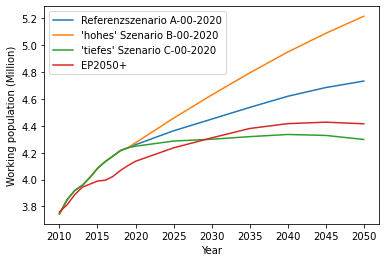

,Referenzszenario A-00-2020,'hohes' Szenario B-00-2020,'tiefes' Szenario C-00-2020,EP2050+
2010,3.744536,3.744536,3.744536,3.759
2011,3.849058,3.849058,3.849058,3.812
2012,3.917975,3.917975,3.917975,3.887
2013,3.956231,3.956231,3.956231,3.943
2014,4.015225,4.015225,4.015225,3.966
2015,4.082667,4.082667,4.082667,3.989
2016,4.132737,4.132737,4.132737,3.995
2017,4.172885,4.172885,4.172885,4.022
2018,4.214956,4.214956,4.214956,4.067
2019,4.236595,4.236595,4.236595,4.104


In [12]:
# Calculate the projections with the updated historical years
years_proj = np.arange(2020,2051,5)

wpop_cross = pd.DataFrame(index=np.append(y_wpop_hist,years_proj).tolist(),columns=wpop_proj.columns)

# Copy historical values
for sce in wpop_proj.columns:
    wpop_cross.loc[y_wpop_hist,sce] = wpop_hist[y_wpop_hist]/1000 #Divide by 1000 to have the values in Million
    # From 2019 to 2020
    wpop_cross.loc[2020,sce] = wpop_cross.loc[2019,sce] * wpop_proj.loc[2020,sce]/wpop_proj.loc[2019,sce]
# From 2025 to 2050
for i in range(1, len(years_proj)):
    wpop_cross.loc[years_proj[i],:] = wpop_cross.loc[years_proj[i-1],:]*wpop_proj.loc[years_proj[i],:]/wpop_proj.loc[years_proj[i-1],:]

# Add the EP2050+ data for comparison
wpop_cross.loc[y_wpop_hist,'EP2050+']=ep2050.loc['Erwerbstätige',y_wpop_hist]/1000
wpop_cross.loc[years_proj,'EP2050+']=ep2050.loc['Erwerbstätige',years_proj]/1000
    
plt.figure()
wpop_cross.plot.line()
plt.xlabel('Year')
plt.ylabel('Working population (Million)')
plt.show()

wpop_cross

## GDP
GDP projections are based on:
* [BFS historical GDP - Expenditure approach (30.08.2022)](https://www.bfs.admin.ch/bfs/de/home/statistiken/volkswirtschaft.assetdetail.23184098.html) 
* [SECO GDP projections (15.06.2022)](https://www.seco.admin.ch/seco/de/home/wirtschaftslage---wirtschaftspolitik/wirtschaftspolitik/Wachstumpolitik/szenarien_bip-entwicklung_schweiz.html)

For the GDP calculations we need additional libraries because the files from SECO are protected and we need to decrypt them first, you can install them using the following lines
* `pip install msoffcrypto-tool`
* `pip install requests`

In [13]:
# Load the historical GDP at current prices
url = 'https://dam-api.bfs.admin.ch/hub/api/dam/assets/23184098/master'

# Read the NOMINAL sheet
# In Mio. Franken, zu laufenden Preisen
gdp_historical_df = pd.read_excel(pd.ExcelFile(url), 'NOMINAL',index_col=[0,1],skiprows=3,nrows= 5, header=[0,1])
# Remove the code from the index 
gdp_historical_df.index = gdp_historical_df.index.droplevel(0)


y_gdp_hist =  np.arange(2010,2022,1)
gdp_hist = pd.Series(dtype = "float")
for y in np.char.mod('%d',y_gdp_hist):
     #This try-except is because in the file some times the year is a string and other times a number
    try: 
        gdp_hist.loc[y]= gdp_historical_df.loc['Bruttoinlandprodukt',(y,'Verwendung')]/1000 # Convert to Billion
    except:
        try: 
            gdp_hist.loc[y]= gdp_historical_df.loc['Bruttoinlandprodukt',(int(y),'Verwendung')]/1000 # Convert to Billion
        except:
            gdp_hist.loc[y]= 0    

# Convert the index from string to integers
gdp_hist.index = gdp_hist.index.astype('int64')

<Figure size 432x288 with 0 Axes>

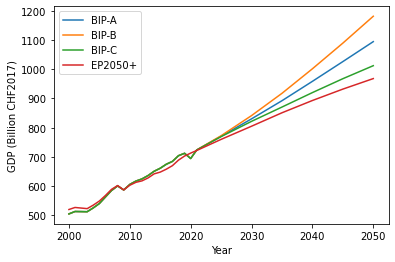

,BIP-A,BIP-B,BIP-C,EP2050+
2000,504.924481,504.924481,504.924481,520.0
2001,513.192421,513.192421,513.192421,527.0
2002,512.861954,512.861954,512.861954,525.0


In [14]:
import msoffcrypto 
import requests


# Load the historical and projected GDP
url = 'https://www.seco.admin.ch/dam/seco/de/dokumente/Wirtschaft/Wirtschaftspolitik/Wachstum/szenarien_bip-entwicklung_ch.xls.download.xls/Szenarien_bip.xls'

resp_gdp = requests.get(url)
file_gdp = msoffcrypto.OfficeFile (io.BytesIO(resp_gdp.content)) # read the original file
file_gdp.load_key (password = 'VelvetSweatshop') # Fill in the password, if it can be opened directly, the default password is 'VelvetSweatshop'

decrypted_workbook = io.BytesIO()
file_gdp.decrypt(decrypted_workbook)

# in Mio. Franken, reale nicht additive Volumen (annual overlap, Referenzjahr 2015) und Veränderungsraten in % gegenüber dem Vorjahr
gdp_proj = pd.read_excel(decrypted_workbook, sheet_name='level',index_col=[0],skiprows=[0,1,2,3,4,5,6,7,8,9],header=[0])


y_gdp = np.append(np.arange(2000,2022,1) ,np.arange(2025,2051,5))
scenarios_gdp = ['BIP-A','BIP-B','BIP-C']
gdp_cross = pd.DataFrame(index=y_gdp.tolist(),columns=scenarios_gdp)

# Define the year at which the constant prices are calculated
y_base = 2017

for y in y_gdp:
    gdp_cross.loc[y,scenarios_gdp] = gdp_hist[y_base]*gdp_proj.loc[y,scenarios_gdp]/gdp_proj.loc[y_base,scenarios_gdp]

# Add the EP2050+ data for comparison
gdp_cross.loc[y_gdp,'EP2050+']=ep2050.loc['BIP',y_gdp]
        
plt.figure()
gdp_cross.plot.line()
plt.xlabel('Year')
plt.ylabel('GDP (Billion CHF2017)')
plt.show()


gdp_cross.head(3)



## Energy reference area (ERA)

ERA projections are based on:
* Historical ERA from BFE, [Analyse des schweizerischen Energieverbrauchs 2000 - 2020 nach Verwendungszwecken (01.11.2021)](https://www.bfe.admin.ch/bfe/en/home/supply/statistics-and-geodata/energy-statistics/analysis-of-energy-consumption-by-specific-use.html)    
* Logaritmic model calibrated with the historical population and GDP (population for residential and commercial sectors; GDP for industry)

In [15]:
# Historical ERA
y_hist_era = np.arange(2000,2021,1)
y_hist_bfe = np.char.mod('%d',y_hist_era)

# Load the historical ERA
era_hist= pd.DataFrame(index= y_hist_bfe.tolist())

# Analyse des schweizerischen Energieverbrauchs 2000 - 2020 nach Verwendungszwecken (01.11.2021)
url = 'https://www.bfe.admin.ch/bfe/en/home/versorgung/statistik-und-geodaten/energiestatistiken/energieverbrauch-nach-verwendungszweck.exturl.html/aHR0cHM6Ly9wdWJkYi5iZmUuYWRtaW4uY2gvZGUvcHVibGljYX/Rpb24vZG93bmxvYWQvMTA2OTU=.html'

# Read the Tabelle11 sheet for the ERA in all sectors
era_file=pd.read_excel(pd.ExcelFile(url), sheet_name='Tabelle11',index_col=[0,1],skiprows=4,nrows=12,header=[0])
# Remove the empty column to the left
era_file.index = era_file.index.droplevel(0)
era_file.index = era_file.index.str.strip()    

era_hist.loc[y_hist_bfe,'residential_withTemporal'] = era_file.loc['- Wohnungen (f)',y_hist_bfe]
era_hist.loc[y_hist_bfe,'commercialwithoutTemporal'] = era_file.loc['- Dienstleistungen (d)',y_hist_bfe]
era_hist.loc[y_hist_bfe,'industrial'] = era_file.loc['- Industrie (d)',y_hist_bfe]

era_hist
# Read the Tabelle19 sheet for the residential ERA  - This is the ERA without the temporal buildings (Zweit- und Ferienwohnungen)
era_res_file=pd.read_excel(pd.ExcelFile(url), sheet_name='Tabelle19',index_col=[0,1],skiprows=4,nrows=8,header=[0])
# Remove the empty column to the left
era_res_file.index = era_res_file.index.droplevel(0)
era_res_file.index = era_res_file.index.str.strip()    

# Calculate the ERA from temporal buildings (Zweit- und Ferienwohnungen)
era_hist.loc[y_hist_bfe,'residential'] = era_res_file.loc['Summe',y_hist_bfe]
era_hist.loc[y_hist_bfe,'temporal'] = era_hist.loc[y_hist_bfe,'residential_withTemporal']-era_hist.loc[y_hist_bfe,'residential']

# Add the ERA from temporal buildings to commercial (Zweit- und Ferienwohnungen)
era_hist.loc[y_hist_bfe,'commercial'] = era_hist.loc[y_hist_bfe,'commercialwithoutTemporal']+era_hist.loc[y_hist_bfe,'temporal']

# Convert the index from string to integers
era_hist.index = era_hist.index.astype('int64')
era_hist.tail(3)

,residential_withTemporal,commercialwithoutTemporal,industrial,residential,temporal,commercial
2018,534.8231,164.356,92.806,474.3591,60.464,224.82
2019,542.049,166.157,93.543,480.7857,61.2633,227.4203
2020,549.2916,168.299,94.544,487.2100,62.0816,230.3806


<Figure size 432x288 with 0 Axes>

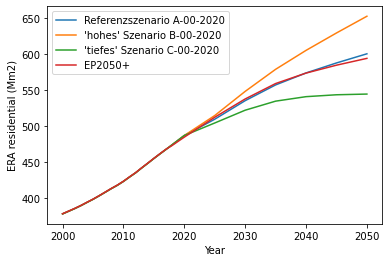

<Figure size 432x288 with 0 Axes>

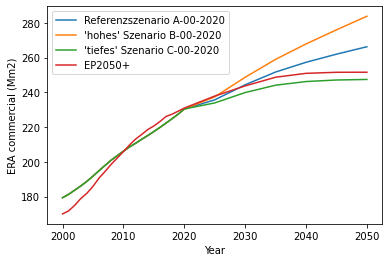

<Figure size 432x288 with 0 Axes>

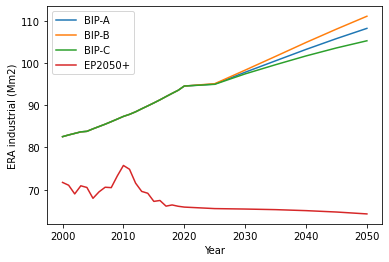

In [16]:
# Calculate the projected ERA
yproj = np.arange(2025,2051,5).tolist()

# Residential
# This function is calibrated with the historical ERA and historical population
era_res_proj =  638.7441 * np.log(pop_cross.loc[2025:2050,:].astype(np.float64))-896.1721  #2010-2018
era_res_cross = pd.DataFrame(index=np.append(y_hist_era,yproj).tolist(),columns=pop_cross.columns)

for sce in pop_cross.columns:
    era_res_cross.loc[y_hist_era,sce] = era_hist.loc[y_hist_era,'residential']
    era_res_cross.loc[yproj,sce] = era_res_proj.loc[yproj,sce]

# Add the EP2050+ data for comparison
era_res_cross.loc[y_hist_era,'EP2050+']=ep2050_ebf.loc['Haushalte',y_hist_era]
era_res_cross.loc[yproj,'EP2050+']=ep2050_ebf.loc['Haushalte',yproj]

plt.figure()
era_res_cross.plot.line()
plt.xlabel('Year')
plt.ylabel('ERA residential (Mm2)')
plt.show()

# Commercial
# This function is calibrated with the historical ERA and historical population
era_com_proj =  215.3779 * np.log(pop_cross.loc[2025:2060,:].astype(np.float64))-238.4284 #2010-2018
era_com_cross = pd.DataFrame(index=np.append(y_hist_era,yproj).tolist(),columns=pop_cross.columns)

for sce in pop_cross.columns:
    era_com_cross.loc[y_hist_era,sce] = era_hist.loc[y_hist_era,'commercial']
    era_com_cross.loc[yproj,sce] = era_com_proj.loc[yproj,sce]

# Add the EP2050+ data for comparison
era_com_cross.loc[y_hist_era,'EP2050+']=ep2050_ebf.loc['Dienstleistungen',y_hist_era]
era_com_cross.loc[yproj,'EP2050+']=ep2050_ebf.loc['Dienstleistungen',yproj]

plt.figure()
era_com_cross.plot.line()
plt.xlabel('Year')
plt.ylabel('ERA commercial (Mm2)')
plt.show()

# Industrial
# This function is calibrated with the historical ERA and historical GDP (in CHF2015)
era_ind_proj =  37.5998 * np.log(gdp_cross.loc[2025:2060,:].astype(np.float64)*gdp_hist[2015]/gdp_hist[2017])-154.0015 #2010-2018 
era_ind_cross = pd.DataFrame(index=np.append(y_hist_era,yproj).tolist(),columns=gdp_cross.columns)

for sce in gdp_cross.columns:
    era_ind_cross.loc[y_hist_era,sce] = era_hist.loc[y_hist_era,'industrial']
    era_ind_cross.loc[yproj,sce] = era_ind_proj.loc[yproj,sce]

# Add the EP2050+ data for comparison
era_ind_cross.loc[y_hist_era,'EP2050+']=ep2050_ebf.loc['Industrie',y_hist_era]
era_ind_cross.loc[yproj,'EP2050+']=ep2050_ebf.loc['Industrie',yproj]

plt.figure()
era_ind_cross.plot.line()
plt.xlabel('Year')
plt.ylabel('ERA industrial (Mm2)')
plt.show()

## Export data for the data package in CROSSDat
Prepares the CSV files for the data package in CROSSDat

In [36]:
def prepareDataCROSSDat(df):
    #Filter the relevant years
    years_filter = np.append(np.arange(2010,2020,1) ,np.arange(2020,2051,5))
    years_filter_alternative = np.append(np.arange(2012,2020,1) ,np.arange(2020,2051,5))
    
    try:
        df_filter  = df.loc[years_filter,:]
    except:
        df_filter  = df.loc[years_filter_alternative,:]
    
    #Remove the EP2050 column
    try:
        df_crossDat=df_filter.drop(columns=['EP2050+'])
    except:
        df_crossDat=df_filter.copy()
        
    print(df_crossDat.to_csv())
    print(df_crossDat.transpose().stack().to_csv())
    

def prepareEraCROSSDat(df):
    years_filter = np.append(np.arange(2000,2020,1) ,np.arange(2020,2051,5))
    
    df_filter  = df.loc[years_filter,:]
    
    #Remove the EP2050 column
    try:
        df_crossDat=df_filter.drop(columns=['EP2050+'])
    except:
        df_crossDat=df_filter.copy()
        
    print(df_crossDat.to_csv())
    
print("Population")
prepareDataCROSSDat(pop_cross)
print("Number of households")
prepareDataCROSSDat(hh_cross)
print("Working population")
prepareDataCROSSDat(wpop_cross)
print("GDP")
prepareDataCROSSDat(gdp_cross)
print("ERA residential")
prepareEraCROSSDat(era_res_cross)
print("ERA commercial")
prepareEraCROSSDat(era_com_cross)
print("ERA industrial")
prepareEraCROSSDat(era_ind_cross)



Population
,Referenzszenario A-00-2020,'hohes' Szenario B-00-2020,'tiefes' Szenario C-00-2020
2010,7.864012,7.864012,7.864012
2011,7.954662,7.954662,7.954662
2012,8.03906,8.03906,8.03906
2013,8.139631,8.139631,8.139631
2014,8.237666,8.237666,8.237666
2015,8.327126,8.327126,8.327126
2016,8.41955,8.41955,8.41955
2017,8.48413,8.48413,8.48413
2018,8.544527,8.544527,8.544527
2019,8.606033,8.606033,8.606033
2020,8.6703,8.6703,8.6703
2025,9.034990621396627,9.107609169878625,8.96157662803398
2030,9.406495653920643,9.597713892655902,9.213720825150633
2035,9.733351060893433,10.068774439604148,9.396538853690963
2040,9.989598917485985,10.491197518948182,9.488566001147817
2045,10.208889272111607,10.89508150194927,9.527629211129065
2050,10.413712010996797,11.297964256656723,9.542140551941658

,,0
Referenzszenario A-00-2020,2010,7.864012
Referenzszenario A-00-2020,2011,7.954662
Referenzszenario A-00-2020,2012,8.03906
Referenzszenario A-00-2020,2013,8.139631
Referenzszenario A-00-2020,2014,8.237666
Re

## Export to latex 

Export the data for the latex report

In [19]:
def prepareDataLatex(df):
    #Filter the relevant years
    years_filter = np.arange(2010,2051,10)
    years_filter_alternative = np.append(2012 ,np.arange(2020,2051,10))
    
    try:
        df_filter  = df.loc[years_filter,:].astype(float).round(1)
        df_filter.loc['2010--2050',:] = (((df.loc[2050,:]/df.loc[2010,:])**(1/40)-1)*100).astype(float).round(2)
        
    except:
        df_filter  = df.loc[years_filter_alternative,:].astype(float).round(1)
        df_filter.loc['2012--2050',:] = (((df.loc[2050,:]/df.loc[2012,:])**(1/38)-1)*100).astype(float).round(2)
    
    
    
    
    df_latex = df_filter.transpose()
    
    print(df_latex.to_latex())
print("Population")
prepareDataLatex(pop_cross)
print("Number of households")
prepareDataLatex(hh_cross)
print("Working population")
prepareDataLatex(wpop_cross)
print("GDP")
prepareDataLatex(gdp_cross)
print("ERA residential")
prepareDataLatex(era_res_cross)
print("ERA commercial")
prepareDataLatex(era_com_cross)
print("ERA industrial")
prepareDataLatex(era_ind_cross)

Population
\begin{tabular}{lrrrrrr}
\toprule
{} &  2010 &  2020 &  2030 &  2040 &  2050 &  2010--2050 \\
\midrule
Referenzszenario A-00-2020  &   7.9 &   8.7 &   9.4 &  10.0 &  10.4 &        0.70 \\
'hohes' Szenario B-00-2020  &   7.9 &   8.7 &   9.6 &  10.5 &  11.3 &        0.91 \\
'tiefes' Szenario C-00-2020 &   7.9 &   8.7 &   9.2 &   9.5 &   9.5 &        0.48 \\
EP2050+                     &   7.8 &   8.7 &   9.5 &  10.0 &  10.3 &        0.68 \\
\bottomrule
\end{tabular}

Number of households
\begin{tabular}{lrrrrrr}
\toprule
{} &  2012 &  2020 &  2030 &  2040 &  2050 &  2012--2050 \\
\midrule
AM-00-2020 &   3.5 &   3.9 &   4.2 &   4.5 &   4.8 &        0.82 \\
BM-00-2020 &   3.5 &   3.9 &   4.3 &   4.7 &   5.1 &        1.01 \\
CM-00-2020 &   3.5 &   3.9 &   4.2 &   4.3 &   4.4 &        0.61 \\
EP2050+    &   3.5 &   3.8 &   4.2 &   4.5 &   4.6 &        0.76 \\
\bottomrule
\end{tabular}

Working population
\begin{tabular}{lrrrrrr}
\toprule
{} &  2010 &  2020 &  2030 &  2040 &  2050 